<a href="https://colab.research.google.com/github/arnavsinghal09/GSoC-QMAML/blob/main/QMAML%20using%20ResNet%20CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Uses only channel HCAL here
!pip install pennylane h5py --quiet

In [2]:
import os
import h5py
import numpy as np
import copy
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pennylane as qml
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Any
from dataclasses import dataclass, field
from sklearn.metrics import (accuracy_score,precision_score, recall_score, f1_score, classification_report, confusion_matrix)
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Mount Google Drive (if running in Colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# --- Cell 2: Configuration / Hyperparameter Setup ---
@dataclass
class Config:
    SAMPLES: int = 80000  # Reduced dataset size
    NUM_QUBITS: int = 6  # Reduced number of qubits
    Q_DEPTH: int = 4  # Reduced circuit depth
    ENCODING_SCHEME: str = 'angle'  # Keep angle encoding for simplicity
    USE_ANALYTIC_GRADIENTS: bool = True
    CNN_OUTPUT_DIM: int = 512  # Increased CNN output dimension
    USE_PRETRAINED_CNN: bool = True
    INNER_STEPS: int = 4  # Reduced inner-loop adaptation steps
    INNER_LR: float = 0.005
    OUTER_LR: float = 0.0003  # Reduced outer learning rate
    META_TASK_TYPE: List[str] = field(default_factory=lambda: ['pt', 'm0'])
    META_BIN_COUNT: int = 5  # Reduced number of bins
    SUPPORT_SIZE: int = 24
    QUERY_SIZE: int = 24
    EPOCHS: int = 20  # Reduced number of epochs
    BATCH_SIZE: int = 24
    EVAL_METRICS: bool = True
    SAVE_BEST_MODEL: bool = True
    CHECKPOINT_DIR: str = '/content/drive/MyDrive/quark-gluon-checkpoints'

config = Config()
os.makedirs(config.CHECKPOINT_DIR, exist_ok=True)

In [5]:
# --- Cell 3: Dataset Loading ---
class JetDataset(Dataset):
    """Custom Dataset for loading jet images, labels, and additional features."""
    def __init__(self, X: np.ndarray, y: np.ndarray, pt: np.ndarray = None, m0: np.ndarray = None):
        self.X = X
        self.y = y
        self.pt = pt
        self.m0 = m0

    def __len__(self) -> int:
        return len(self.y)

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, int]:
        return self.X[idx], self.y[idx]

def load_datasets(config: Config) -> Tuple[Dataset, Dataset]:
    """Load and return separate train and test datasets."""
    # Paths to datasets
    train_path = '/content/drive/MyDrive/quark-gluon-dataset/quark-gluon_train-set_n793900.hdf5'
    test1_path = '/content/drive/MyDrive/quark-gluon-dataset/quark-gluon_test-set_n139306.hdf5'

    # Load train dataset
    with h5py.File(train_path, 'r') as f:
        X_train = f['X_jets'][:config.SAMPLES]
        y_train = f['y'][:config.SAMPLES]
        pt_train = f['pt'][:config.SAMPLES]
        m0_train = f['m0'][:config.SAMPLES]

    # Load test dataset
    with h5py.File(test1_path, 'r') as f:
        X_test = f['X_jets'][:config.SAMPLES]
        y_test = f['y'][:config.SAMPLES]
        pt_test = f['pt'][:config.SAMPLES]
        m0_test = f['m0'][:config.SAMPLES]

    # Create train and test datasets
    train_dataset = JetDataset(X_train, y_train, pt_train, m0_train)
    test_dataset = JetDataset(X_test, y_test, pt_test, m0_test)

    return train_dataset, test_dataset

# Load train and test datasets
train_dataset, test_dataset = load_datasets(config)


In [6]:
def generate_meta_tasks(
    dataset: Dataset,
    meta_task_types: List[str],  # List of meta-task types (e.g., ['pt', 'm0'])
    bin_count: int,
    support_size: int,
    query_size: int,
    num_tasks_per_bin: int = 3,  # Generate multiple tasks per bin
    random_seed: int = 42,  # Seed for reproducibility
) -> List[Dict[str, Any]]:
    """
    Generate meta-tasks using both `pt` and `m0` features for diversity.
    Args:
        dataset: The dataset containing jet images and features.
        meta_task_types: List of meta-task types to use (e.g., ['pt', 'm0']).
        bin_count: Number of bins for meta-task generation.
        support_size: Size of the support set.
        query_size: Size of the query set.
        num_tasks_per_bin: Number of tasks to generate per bin.
        random_seed: Seed for reproducibility.
    Returns:
        List of meta-tasks, each containing support and query sets.
    """
    # Set random seed for reproducibility
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

    # Extract data and labels
    X, y = [], []
    for i in range(len(dataset)):
        X_sample, y_sample = dataset[i]
        X.append(X_sample)
        y.append(y_sample)
    X = np.array(X)
    y = np.array(y)

    # Retain only the desired channel (e.g., HCAL, channel 1)
    X = X[:, :, :, 1:2]  # Keep only channel 1 (HCAL)

    meta_tasks = []
    bin_task_counts = []

    # Alternate between `pt` and `m0` for meta-task generation
    for feature_type in meta_task_types:
        feature = getattr(dataset, feature_type)
        bins = np.linspace(feature.min(), feature.max(), bin_count + 1)

        for i in range(len(bins) - 1):
            bin_indices = np.where((feature >= bins[i]) & (feature < bins[i + 1]))[0]
            if len(bin_indices) < support_size + query_size:
                print(f"Skipping bin {i} for feature '{feature_type}' due to insufficient samples.")
                continue  # Skip bins with insufficient samples

            # Ensure balanced classes in support and query sets
            class_0_indices = bin_indices[y[bin_indices] == 0]
            class_1_indices = bin_indices[y[bin_indices] == 1]
            if len(class_0_indices) < support_size // 2 or len(class_1_indices) < support_size // 2:
                print(f"Skipping bin {i} for feature '{feature_type}' due to class imbalance.")
                continue  # Skip bins with insufficient samples for balanced classes

            for _ in range(num_tasks_per_bin):
                # Sample support and query sets
                support_indices = np.concatenate([
                    np.random.choice(class_0_indices, support_size // 2, replace=False),
                    np.random.choice(class_1_indices, support_size // 2, replace=False),
                ])
                query_indices = np.concatenate([
                    np.random.choice(class_0_indices, query_size // 2, replace=False),
                    np.random.choice(class_1_indices, query_size // 2, replace=False),
                ])

                # Create meta-task
                meta_tasks.append({
                    "support_X": torch.tensor(X[support_indices], dtype=torch.float32).permute(0, 3, 1, 2),  # Fix shape
                    "support_y": torch.tensor(y[support_indices], dtype=torch.long),
                    "query_X": torch.tensor(X[query_indices], dtype=torch.float32).permute(0, 3, 1, 2),  # Fix shape
                    "query_y": torch.tensor(y[query_indices], dtype=torch.long),
                })
            bin_task_counts.append(num_tasks_per_bin)

    # Shuffle tasks to ensure diversity
    np.random.shuffle(meta_tasks)

    print(f"Total meta-tasks generated: {len(meta_tasks)}")
    return meta_tasks

# Generate meta-tasks using both `pt` and `m0`
meta_task_types = ['pt', 'm0']  # Use both features for meta-task generation
meta_tasks = generate_meta_tasks(
    train_dataset,
    meta_task_types=config.META_TASK_TYPE,
    bin_count=config.META_BIN_COUNT,
    support_size=config.SUPPORT_SIZE,
    query_size=config.QUERY_SIZE,
)

Skipping bin 4 for feature 'pt' due to insufficient samples.
Skipping bin 4 for feature 'm0' due to insufficient samples.
Total meta-tasks generated: 24


In [7]:
# --- Cell 5: CNN Feature Extractor (drop-in replacement) ---
class CNNFeatureExtractor(nn.Module):
    """CNN-based feature extractor using pretrained ResNet-18, preserving pretrained conv1."""
    def __init__(self, output_dim: int, num_qubits: int):
        super(CNNFeatureExtractor, self).__init__()
        # keep pretrained conv1 (3-channel)
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

        # classification head -> bottleneck -> output_dim
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, output_dim)
        )

        self.output_layer = nn.Linear(output_dim, num_qubits)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, 1, H, W]
        x = x.float()
        # simple per-image standardization (helps stability across varied intensities)
        x = (x - x.mean(dim=(2,3), keepdim=True)) / (x.std(dim=(2,3), keepdim=True) + 1e-5)
        # repeat HCAL to 3 channels so we can use pretrained conv1
        if x.size(1) == 1:
            x = x.repeat(1, 3, 1, 1)

        features = self.model(x)                       # -> [B, output_dim]
        bounded_features = np.pi * torch.tanh(features)  # [-π, π]
        logits = self.output_layer(bounded_features)   # -> [B, num_qubits]
        return logits


In [8]:
import functools

class PQCModel(nn.Module):
    """Parameterized Quantum Circuit (PQC) model."""
    def __init__(self, num_qubits: int, depth: int, init_type: str = "qmaml"):
        super(PQCModel, self).__init__()
        self.num_qubits = num_qubits
        self.depth = depth
        self.dev = qml.device("default.qubit", wires=num_qubits)

        # Define the quantum circuit
        def circuit(inputs: torch.Tensor, weights: torch.Tensor) -> torch.Tensor:
            # Angle encoding
            for i in range(num_qubits):
                qml.RY(inputs[i], wires=i)
            # Variational layers
            qml.templates.StronglyEntanglingLayers(weights, wires=range(num_qubits))
            return qml.expval(qml.PauliZ(0))  # Expectation value of Z on the first qubit

        # Create the QNode
        self.circuit = qml.QNode(circuit, self.dev, interface="torch")

        # Initialize weights based on init_type
        if init_type == "zero":
            self.weights = nn.Parameter(torch.zeros(depth, num_qubits, 3))
        elif init_type == "pi":
            self.weights = nn.Parameter(torch.full((depth, num_qubits, 3), np.pi))
        elif init_type == "uniform":
            self.weights = nn.Parameter(torch.rand(depth, num_qubits, 3) * 0.05 * np.pi)
        elif init_type == "gaussian":
            gamma = 1 / (4 * num_qubits * (depth + 2))
            self.weights = nn.Parameter(torch.normal(0, gamma, size=(depth, num_qubits, 3)))
        else:  # Default to QMAML initialization
            self.weights = nn.Parameter(torch.randn(depth, num_qubits, 3))

        self.fc = nn.Linear(1, 2)  # Map scalar output to two logits

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.size(0)
        outputs = torch.zeros(batch_size, 1)  # Placeholder for quantum outputs
        for i in range(batch_size):
            outputs[i] = self.circuit(x[i], self.weights)
        logits = self.fc(outputs)
        return logits

In [9]:
# --- Cell 7: Hybrid Model ---
class HybridModel(nn.Module):
    """Hybrid Quantum-Classical Model."""
    def __init__(self, cnn: nn.Module, pqc: nn.Module):
        super(HybridModel, self).__init__()
        self.cnn = cnn
        self.pqc = pqc

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.cnn(x)
        logits = self.pqc(features)
        return logits

In [10]:
# --- Cell 8: Inner Loop (minor stability tweaks) ---
def inner_loop_adaptation(
    model: nn.Module,
    support_X: torch.Tensor,
    support_y: torch.Tensor,
    inner_steps: int,
    inner_lr: float,
) -> Tuple[nn.Module, List[float]]:
    adapted_model = copy.deepcopy(model)
    adapted_model.train()
    optimizer = torch.optim.SGD(adapted_model.parameters(), lr=inner_lr, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()

    gradient_norms = []
    for _ in range(inner_steps):
        optimizer.zero_grad()
        logits = adapted_model(support_X)
        loss = loss_fn(logits, support_y)
        loss.backward()

        # L2 gradient norm (for logging)
        g2 = 0.0
        for p in adapted_model.parameters():
            if p.grad is not None:
                g2 += p.grad.norm(2).item() ** 2
        gradient_norms.append(g2 ** 0.5)

        # optional: clip to reduce spikes
        torch.nn.utils.clip_grad_norm_(adapted_model.parameters(), max_norm=1.0)
        optimizer.step()

    return adapted_model, gradient_norms


In [11]:
# --- Cell 8: Outer Loop (Reptile meta-update + fixed reporting) ---
def outer_loop_meta_update(
    model: nn.Module,
    meta_tasks: List[Dict[str, Any]],
    test_meta_tasks: List[Dict[str, Any]],
    outer_lr: float,
    eval_metrics: bool,
) -> Dict[str, List[float]]:
    optimizer = torch.optim.Adam(model.parameters(), lr=outer_lr, weight_decay=1e-4)
    loss_fn = nn.CrossEntropyLoss()

    meta_loss_history, gradient_norm_history = [], []
    training_loss_history, validation_loss_history = [], []

    metrics_history = {"accuracy": [], "precision": [], "recall": [], "f1_score": []}
    test_metrics_history = {"accuracy": [], "precision": [], "recall": [], "f1_score": []}

    best_accuracy = 0.0

    for epoch in range(config.EPOCHS):
        model.train()
        meta_loss = 0.0
        training_loss = 0.0
        validation_loss = 0.0
        epoch_accuracies, epoch_precisions, epoch_recalls, epoch_f1s = [], [], [], []
        epoch_gradient_norms = []

        # -------- Train / Meta-update (Reptile) --------
        for task in meta_tasks:
            adapted_model, gradient_norms = inner_loop_adaptation(
                model, task["support_X"], task["support_y"], config.INNER_STEPS, config.INNER_LR
            )
            epoch_gradient_norms.extend(gradient_norms)

            # Evaluate adapted model on its query set (for logging only)
            with torch.no_grad():
                query_logits = adapted_model(task["query_X"])
                query_loss = loss_fn(query_logits, task["query_y"])
                meta_loss += query_loss.item()
                training_loss += query_loss.item()

                if eval_metrics:
                    preds = torch.argmax(query_logits, dim=1)
                    accuracy = (preds == task["query_y"]).float().mean().item()
                    precision = precision_score(task["query_y"].cpu(), preds.cpu(), zero_division=0)
                    recall = recall_score(task["query_y"].cpu(), preds.cpu(), zero_division=0)
                    f1 = f1_score(task["query_y"].cpu(), preds.cpu(), zero_division=0)
                    epoch_accuracies.append(accuracy)
                    epoch_precisions.append(precision)
                    epoch_recalls.append(recall)
                    epoch_f1s.append(f1)

            # --- Reptile meta-step: θ ← θ + α (φ − θ) implemented via gradients ---
            optimizer.zero_grad()
            with torch.no_grad():
                for p, p_adapt in zip(model.parameters(), adapted_model.parameters()):
                    if p.grad is None:
                        p.grad = torch.zeros_like(p)
                    # Set grad to (θ - φ). Adam/SGD step does: θ_new = θ - lr*(θ-φ) = θ + lr*(φ-θ)
                    p.grad.copy_(p.data - p_adapt.data)
            optimizer.step()

        # -------- Validation on unseen tasks (with adaptation on their support) --------
        model.eval()
        val_accs, val_precs, val_recalls, val_f1s = [], [], [], []
        for test_task in test_meta_tasks:
            # Adapt a temporary copy for validation
            adapted_eval, _ = inner_loop_adaptation(
                model, test_task["support_X"], test_task["support_y"], config.INNER_STEPS, config.INNER_LR
            )
            with torch.no_grad():
                q_logits = adapted_eval(test_task["query_X"])
                q_loss = loss_fn(q_logits, test_task["query_y"])
                validation_loss += q_loss.item()

                preds = torch.argmax(q_logits, dim=1)
                val_accs.append((preds == test_task["query_y"]).float().mean().item())
                val_precs.append(precision_score(test_task["query_y"].cpu(), preds.cpu(), zero_division=0))
                val_recalls.append(recall_score(test_task["query_y"].cpu(), preds.cpu(), zero_division=0))
                val_f1s.append(f1_score(test_task["query_y"].cpu(), preds.cpu(), zero_division=0))

        # -------- Bookkeeping --------
        meta_loss /= max(1, len(meta_tasks))
        training_loss /= max(1, len(meta_tasks))
        validation_loss /= max(1, len(test_meta_tasks))
        meta_loss_history.append(meta_loss)
        training_loss_history.append(training_loss)
        validation_loss_history.append(validation_loss)
        gradient_norm_history.append(float(np.mean(epoch_gradient_norms)) if epoch_gradient_norms else 0.0)

        if eval_metrics:
            avg_accuracy  = float(np.mean(epoch_accuracies)) if epoch_accuracies else 0.0
            avg_precision = float(np.mean(epoch_precisions)) if epoch_precisions else 0.0
            avg_recall    = float(np.mean(epoch_recalls)) if epoch_recalls else 0.0
            avg_f1        = float(np.mean(epoch_f1s)) if epoch_f1s else 0.0

            metrics_history["accuracy"].append(avg_accuracy)
            metrics_history["precision"].append(avg_precision)
            metrics_history["recall"].append(avg_recall)
            metrics_history["f1_score"].append(avg_f1)

            # validation metrics
            t_acc  = float(np.mean(val_accs))  if val_accs  else 0.0
            t_prec = float(np.mean(val_precs)) if val_precs else 0.0
            t_rec  = float(np.mean(val_recalls)) if val_recalls else 0.0
            t_f1   = float(np.mean(val_f1s))   if val_f1s   else 0.0

            test_metrics_history["accuracy"].append(t_acc)
            test_metrics_history["precision"].append(t_prec)
            test_metrics_history["recall"].append(t_rec)
            test_metrics_history["f1_score"].append(t_f1)

            if config.SAVE_BEST_MODEL and avg_accuracy > best_accuracy:
                best_accuracy = avg_accuracy
                torch.save(model.state_dict(), os.path.join(config.CHECKPOINT_DIR, "best_model.pth"))

        print(
            f"Epoch {epoch + 1}/{config.EPOCHS} | "
            f"Meta-loss: {meta_loss:.4f} | Train Loss: {training_loss:.4f} | Val Loss: {validation_loss:.4f} | "
            f"Train Acc: {metrics_history['accuracy'][-1] if metrics_history['accuracy'] else 0.0:.4f} | "
            f"Val Acc: {test_metrics_history['accuracy'][-1] if test_metrics_history['accuracy'] else 0.0:.4f}"
        )

    return {
        "meta_loss": meta_loss_history,
        "training_loss": training_loss_history,
        "validation_loss": validation_loss_history,
        "gradient_norms": gradient_norm_history,
        **metrics_history,
        "test_metrics": test_metrics_history,
    }


In [12]:
# --- Cell 10: Evaluation and Visualization (add accuracy plot) ---
def plot_training_results(results: Dict[str, List[float]], init_type: str):
    epochs = range(1, len(results["meta_loss"]) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, results["meta_loss"], label="Meta-loss")
    plt.xlabel("Epoch"); plt.ylabel("Meta-loss")
    plt.title(f"Meta-loss over Epochs ({init_type.capitalize()} Initialization)")
    plt.legend(); plt.grid(True); plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, results["training_loss"], label="Training Loss")
    plt.xlabel("Epoch"); plt.ylabel("Training Loss")
    plt.title(f"Training Loss over Epochs ({init_type.capitalize()} Initialization)")
    plt.legend(); plt.grid(True); plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, results["validation_loss"], label="Validation Loss")
    plt.xlabel("Epoch"); plt.ylabel("Validation Loss")
    plt.title(f"Validation Loss over Epochs ({init_type.capitalize()} Initialization)")
    plt.legend(); plt.grid(True); plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, results["gradient_norms"], label="Gradient Norms")
    plt.xlabel("Epoch"); plt.ylabel("Gradient Norms")
    plt.title(f"Gradient Norms over Epochs ({init_type.capitalize()} Initialization)")
    plt.legend(); plt.grid(True); plt.show()

    if "accuracy" in results and len(results["accuracy"]) == len(list(epochs)):
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, results["accuracy"], label="Train Accuracy")
        if "test_metrics" in results and "accuracy" in results["test_metrics"]:
            plt.plot(epochs, results["test_metrics"]["accuracy"], label="Val Accuracy")
        plt.xlabel("Epoch"); plt.ylabel("Accuracy")
        plt.title(f"Accuracy over Epochs ({init_type.capitalize()} Initialization)")
        plt.legend(); plt.grid(True); plt.show()


In [13]:
def plot_comparison(results: Dict[str, Dict[str, List[float]]]):
    """Compare meta-loss, training loss, and validation loss across all initialization techniques."""
    epochs = range(1, len(next(iter(results.values()))["meta_loss"]) + 1)

    # Compare meta-loss across initializations
    plt.figure(figsize=(12, 8))
    for init_type, result in results.items():
        plt.plot(epochs, result["meta_loss"], label=f"{init_type.capitalize()} Meta-loss")
    plt.xlabel("Epoch")
    plt.ylabel("Meta-loss")
    plt.title("Meta-loss Comparison Across Initializations")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Compare training loss across initializations
    plt.figure(figsize=(12, 8))
    for init_type, result in results.items():
        plt.plot(epochs, result["training_loss"], label=f"{init_type.capitalize()} Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.title("Training Loss Comparison Across Initializations")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Compare validation loss across initializations
    plt.figure(figsize=(12, 8))
    for init_type, result in results.items():
        plt.plot(epochs, result["validation_loss"], label=f"{init_type.capitalize()} Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Loss")
    plt.title("Validation Loss Comparison Across Initializations")
    plt.legend()
    plt.grid(True)
    plt.show()

Skipping bin 4 for feature 'pt' due to insufficient samples.
Skipping bin 4 for feature 'm0' due to insufficient samples.
Total meta-tasks generated: 24
Testing initialization: qmaml


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 1/20 | Meta-loss: 0.6840 | Train Loss: 0.6840 | Val Loss: 0.6769 | Train Acc: 0.5573 | Val Acc: 0.5972
Epoch 2/20 | Meta-loss: 0.6676 | Train Loss: 0.6676 | Val Loss: 0.6704 | Train Acc: 0.6319 | Val Acc: 0.6094
Epoch 3/20 | Meta-loss: 0.6592 | Train Loss: 0.6592 | Val Loss: 0.6790 | Train Acc: 0.6493 | Val Acc: 0.6007
Epoch 4/20 | Meta-loss: 0.6537 | Train Loss: 0.6537 | Val Loss: 0.6715 | Train Acc: 0.6615 | Val Acc: 0.5990
Epoch 5/20 | Meta-loss: 0.6482 | Train Loss: 0.6482 | Val Loss: 0.6785 | Train Acc: 0.6649 | Val Acc: 0.5851
Epoch 6/20 | Meta-loss: 0.6564 | Train Loss: 0.6564 | Val Loss: 0.6802 | Train Acc: 0.6476 | Val Acc: 0.5938
Epoch 7/20 | Meta-loss: 0.6424 | Train Loss: 0.6424 | Val Loss: 0.6761 | Train Acc: 0.6788 | Val Acc: 0.5799
Epoch 8/20 | Meta-loss: 0.6534 | Train Loss: 0.6534 | Val Loss: 0.6886 | Train Acc: 0.6250 | Val Acc: 0.5608
Epoch 9/20 | Meta-loss: 0.6473 | Train Loss: 0.6473 | Val Loss: 0.6977 | Train Acc: 0.6424 | Val Acc: 0.5417
Epoch 10/20 | Meta-

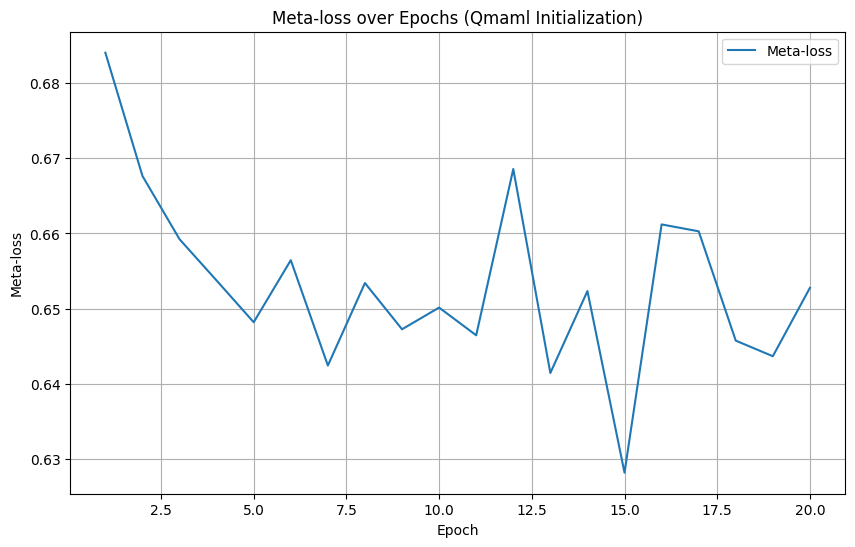

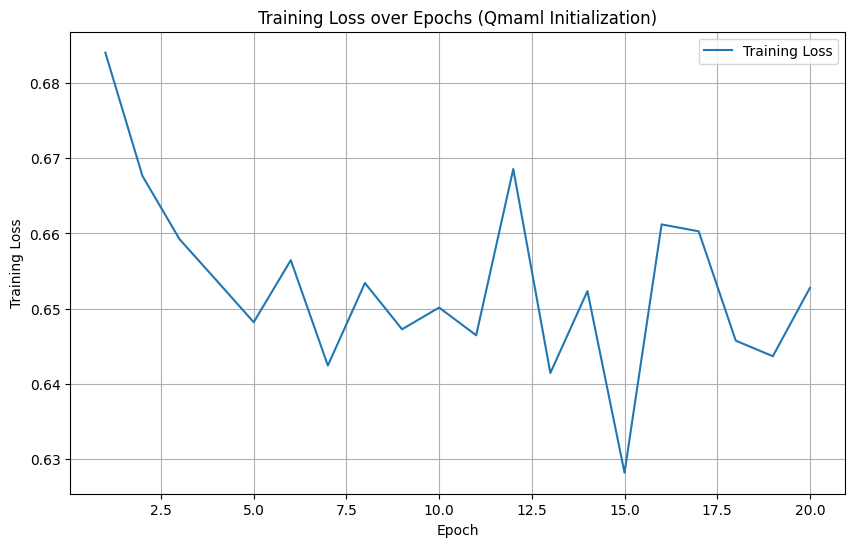

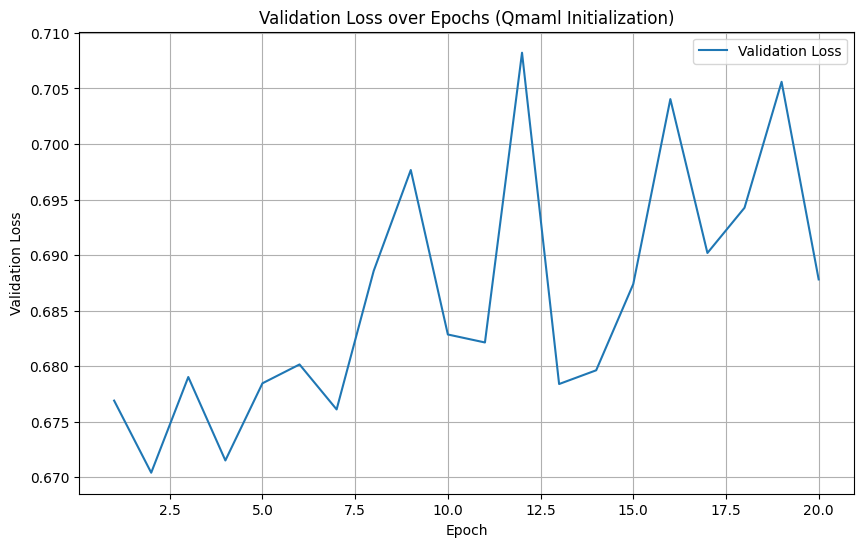

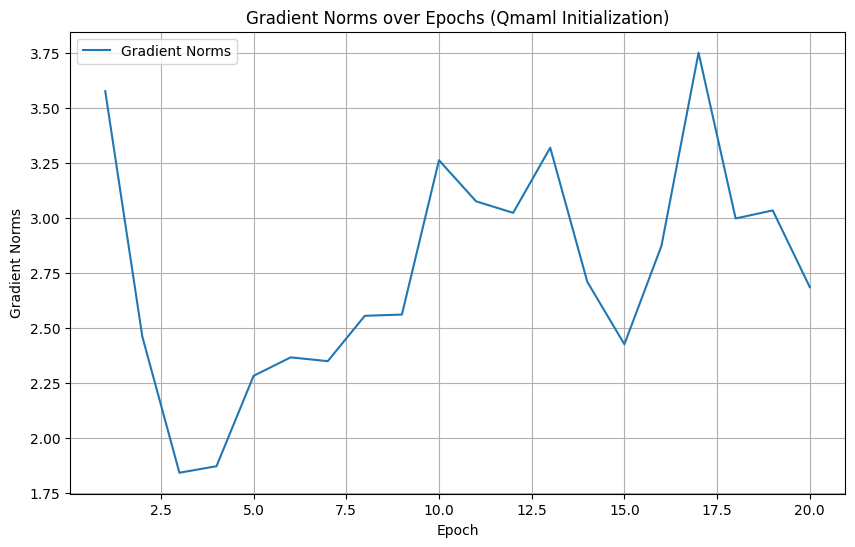

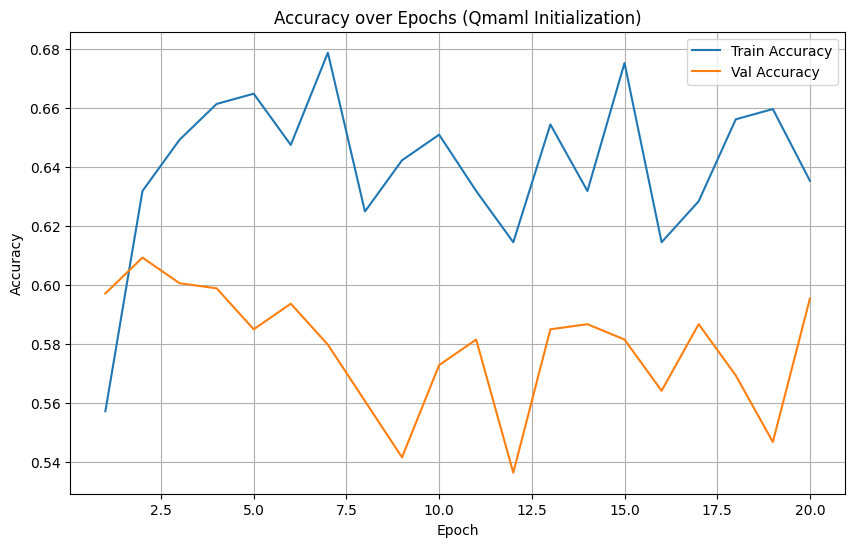

Testing initialization: zero


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 1/20 | Meta-loss: 0.6982 | Train Loss: 0.6982 | Val Loss: 0.6723 | Train Acc: 0.5052 | Val Acc: 0.5469
Epoch 2/20 | Meta-loss: 0.6667 | Train Loss: 0.6667 | Val Loss: 0.6753 | Train Acc: 0.6372 | Val Acc: 0.6076
Epoch 3/20 | Meta-loss: 0.6703 | Train Loss: 0.6703 | Val Loss: 0.6755 | Train Acc: 0.6198 | Val Acc: 0.6146
Epoch 4/20 | Meta-loss: 0.6599 | Train Loss: 0.6599 | Val Loss: 0.6745 | Train Acc: 0.6545 | Val Acc: 0.6076
Epoch 5/20 | Meta-loss: 0.6604 | Train Loss: 0.6604 | Val Loss: 0.6768 | Train Acc: 0.6545 | Val Acc: 0.5799
Epoch 6/20 | Meta-loss: 0.6520 | Train Loss: 0.6520 | Val Loss: 0.6646 | Train Acc: 0.6562 | Val Acc: 0.6198
Epoch 7/20 | Meta-loss: 0.6607 | Train Loss: 0.6607 | Val Loss: 0.6813 | Train Acc: 0.6701 | Val Acc: 0.5885
Epoch 8/20 | Meta-loss: 0.6585 | Train Loss: 0.6585 | Val Loss: 0.6823 | Train Acc: 0.6510 | Val Acc: 0.5833
Epoch 9/20 | Meta-loss: 0.6569 | Train Loss: 0.6569 | Val Loss: 0.6729 | Train Acc: 0.6528 | Val Acc: 0.6094
Epoch 10/20 | Meta-

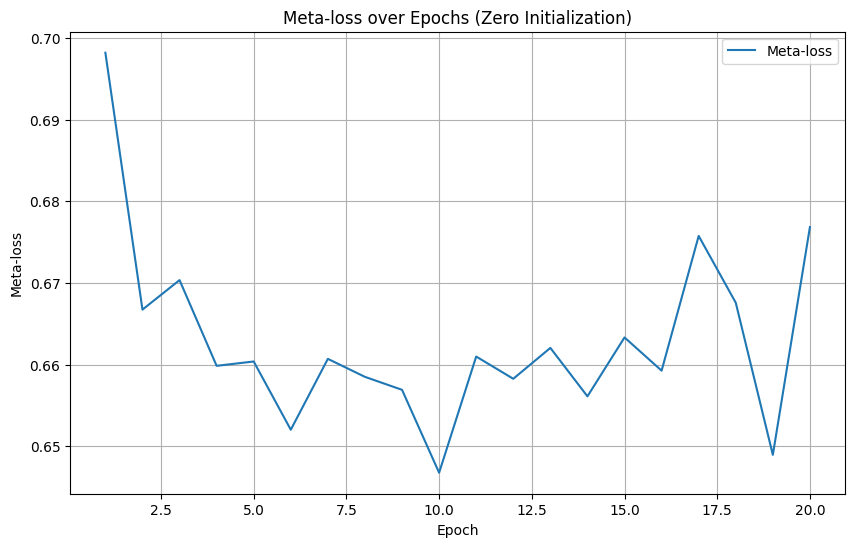

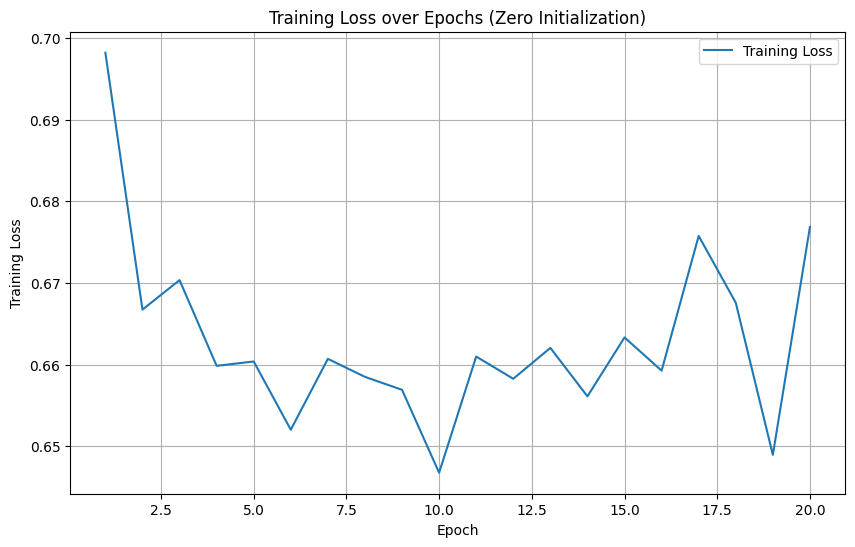

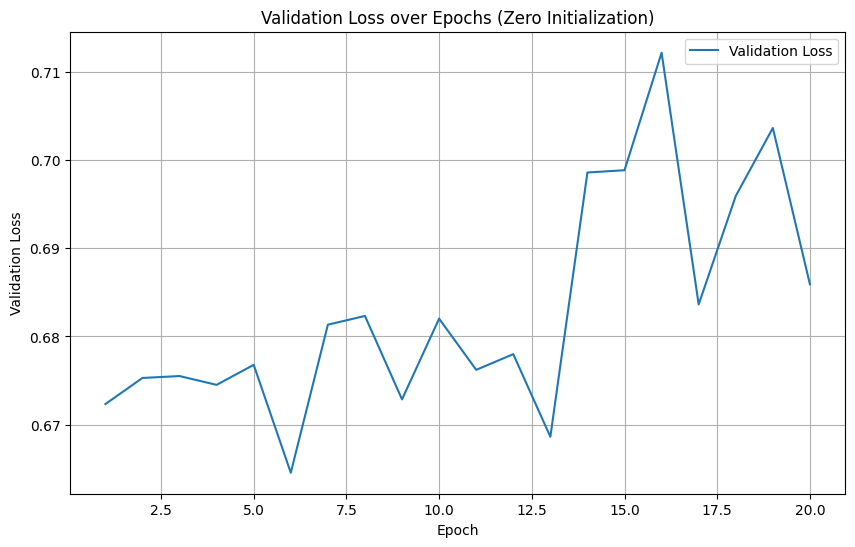

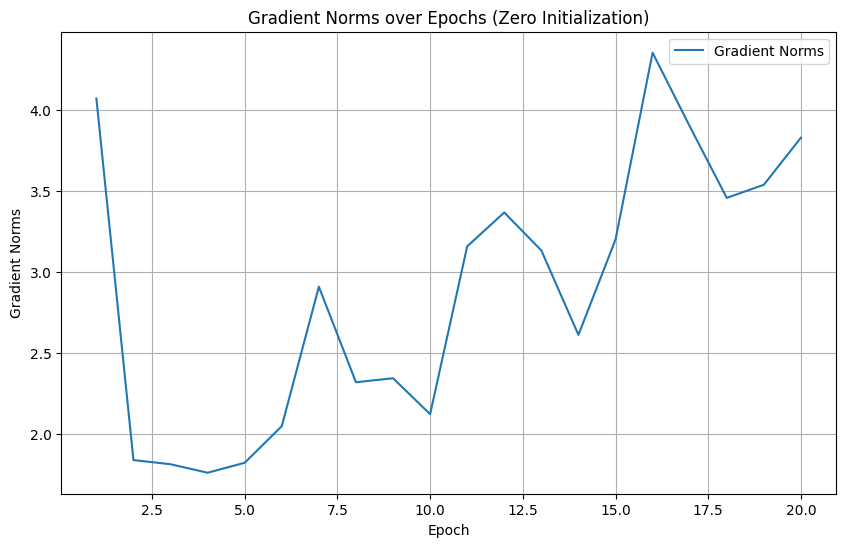

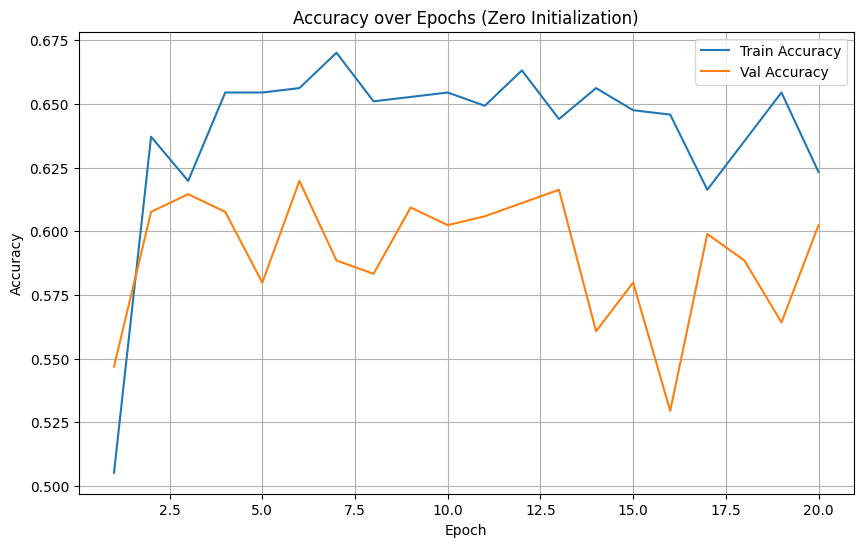

Testing initialization: pi


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 1/20 | Meta-loss: 0.6849 | Train Loss: 0.6849 | Val Loss: 0.6860 | Train Acc: 0.5087 | Val Acc: 0.4931
Epoch 2/20 | Meta-loss: 0.6878 | Train Loss: 0.6878 | Val Loss: 0.6963 | Train Acc: 0.5347 | Val Acc: 0.5087
Epoch 3/20 | Meta-loss: 0.6838 | Train Loss: 0.6838 | Val Loss: 0.6927 | Train Acc: 0.5208 | Val Acc: 0.5000
Epoch 4/20 | Meta-loss: 0.6784 | Train Loss: 0.6784 | Val Loss: 0.6832 | Train Acc: 0.4983 | Val Acc: 0.5226
Epoch 5/20 | Meta-loss: 0.6801 | Train Loss: 0.6801 | Val Loss: 0.6851 | Train Acc: 0.5139 | Val Acc: 0.5625
Epoch 6/20 | Meta-loss: 0.6639 | Train Loss: 0.6639 | Val Loss: 0.6718 | Train Acc: 0.5816 | Val Acc: 0.5833
Epoch 7/20 | Meta-loss: 0.6574 | Train Loss: 0.6574 | Val Loss: 0.6853 | Train Acc: 0.5990 | Val Acc: 0.5347
Epoch 8/20 | Meta-loss: 0.6471 | Train Loss: 0.6471 | Val Loss: 0.6715 | Train Acc: 0.6354 | Val Acc: 0.5868
Epoch 9/20 | Meta-loss: 0.6579 | Train Loss: 0.6579 | Val Loss: 0.6921 | Train Acc: 0.6354 | Val Acc: 0.5417
Epoch 10/20 | Meta-

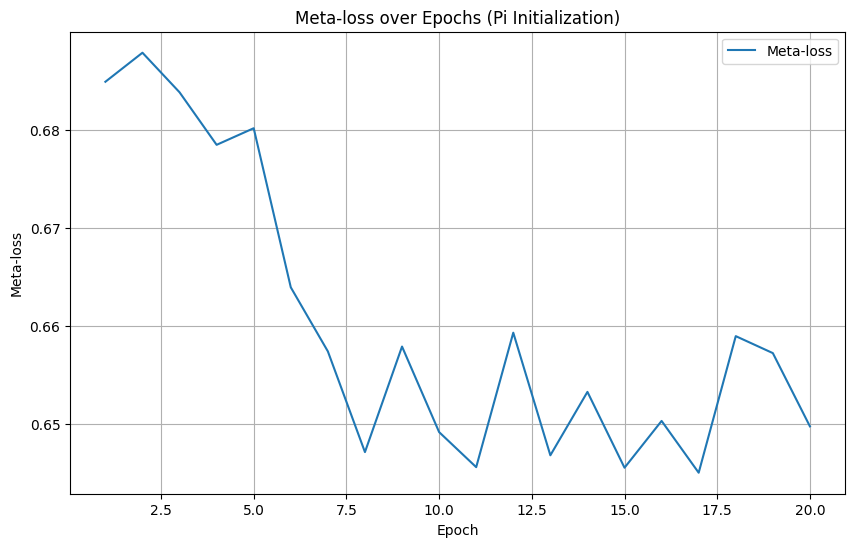

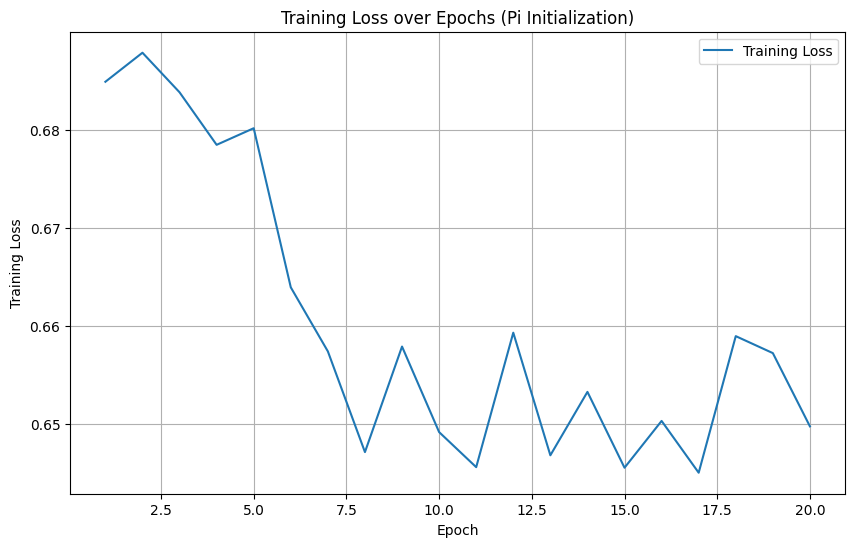

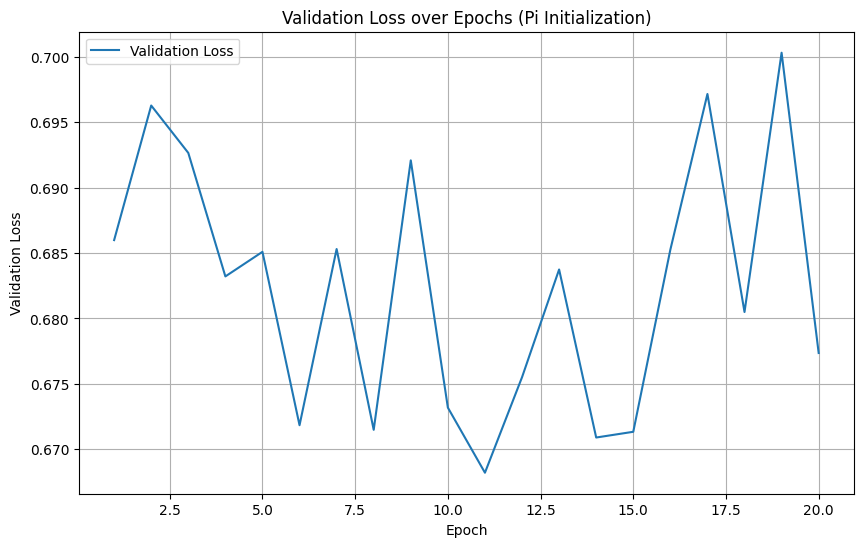

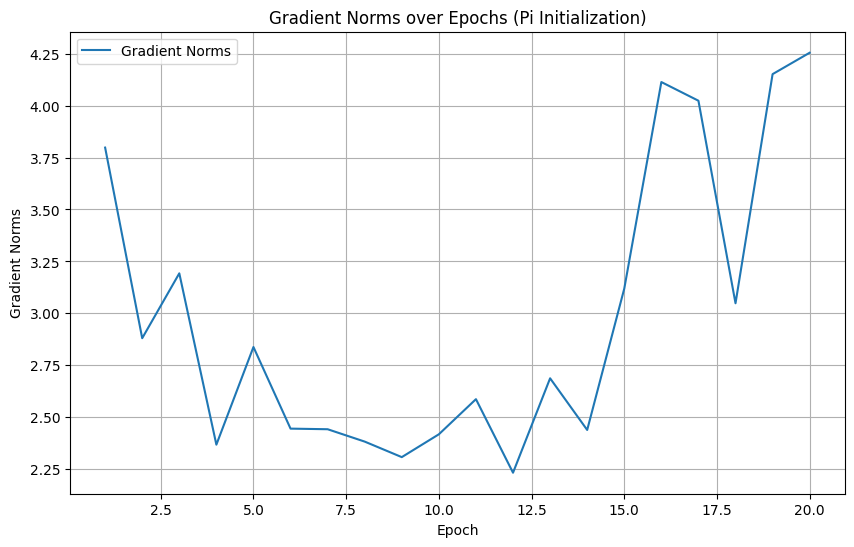

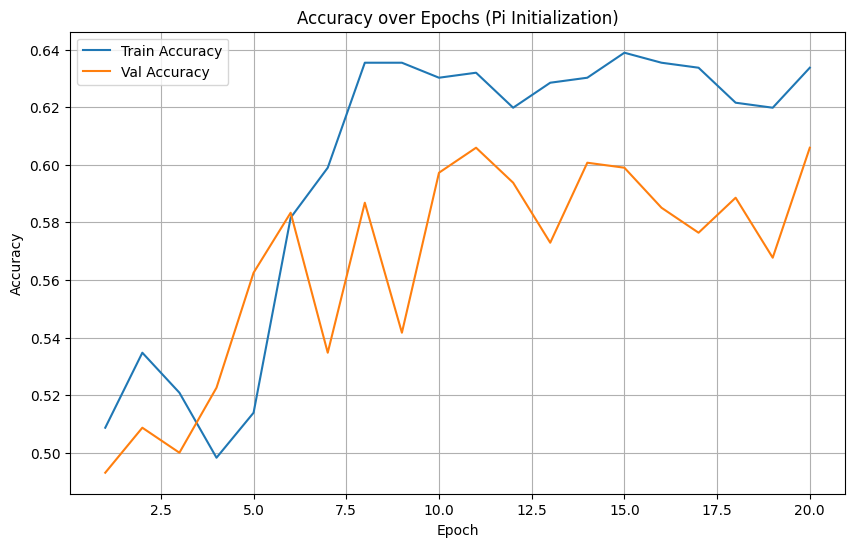

Testing initialization: uniform


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 1/20 | Meta-loss: 0.8145 | Train Loss: 0.8145 | Val Loss: 0.8028 | Train Acc: 0.5000 | Val Acc: 0.5000
Epoch 2/20 | Meta-loss: 0.7701 | Train Loss: 0.7701 | Val Loss: 0.7592 | Train Acc: 0.5000 | Val Acc: 0.5000
Epoch 3/20 | Meta-loss: 0.7437 | Train Loss: 0.7437 | Val Loss: 0.7490 | Train Acc: 0.5000 | Val Acc: 0.5000
Epoch 4/20 | Meta-loss: 0.7444 | Train Loss: 0.7444 | Val Loss: 0.7490 | Train Acc: 0.5000 | Val Acc: 0.5000
Epoch 5/20 | Meta-loss: 0.7381 | Train Loss: 0.7381 | Val Loss: 0.7401 | Train Acc: 0.5000 | Val Acc: 0.5000
Epoch 6/20 | Meta-loss: 0.7381 | Train Loss: 0.7381 | Val Loss: 0.7451 | Train Acc: 0.5000 | Val Acc: 0.5000
Epoch 7/20 | Meta-loss: 0.7427 | Train Loss: 0.7427 | Val Loss: 0.7355 | Train Acc: 0.5000 | Val Acc: 0.5000
Epoch 8/20 | Meta-loss: 0.7289 | Train Loss: 0.7289 | Val Loss: 0.7298 | Train Acc: 0.5000 | Val Acc: 0.5000
Epoch 9/20 | Meta-loss: 0.7195 | Train Loss: 0.7195 | Val Loss: 0.7287 | Train Acc: 0.5000 | Val Acc: 0.5000
Epoch 10/20 | Meta-

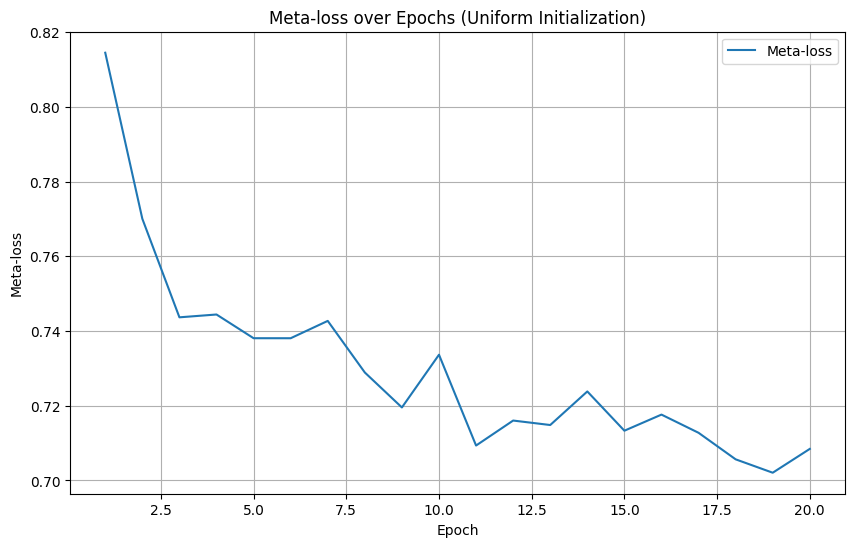

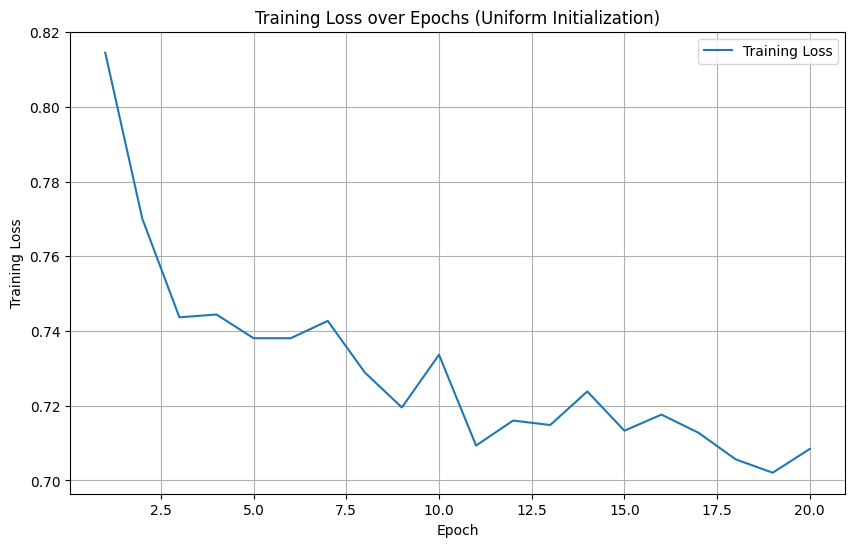

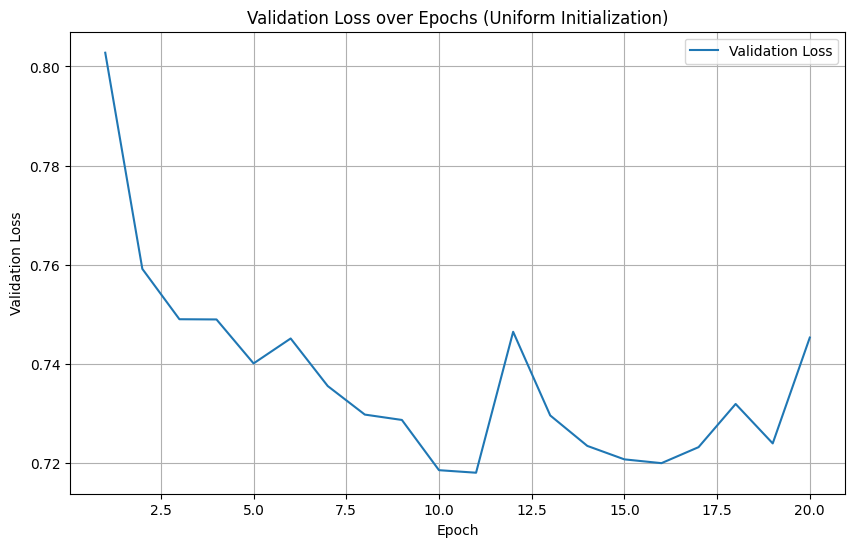

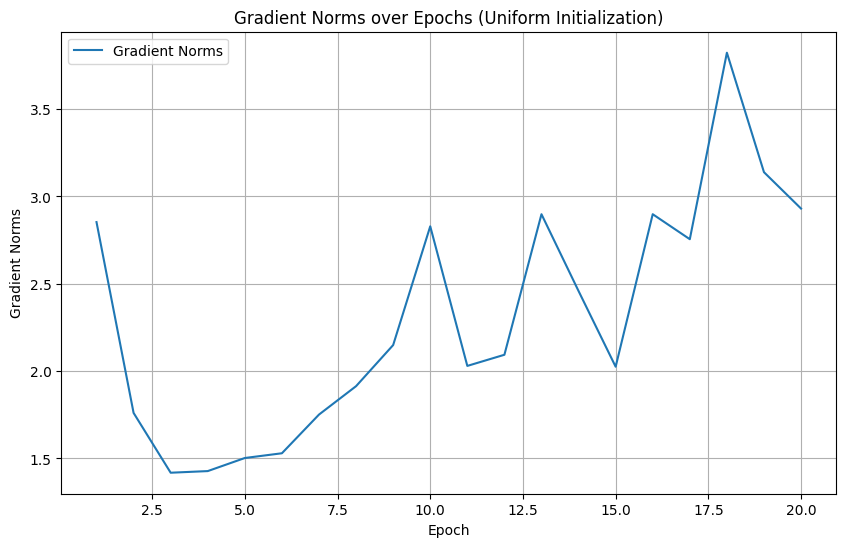

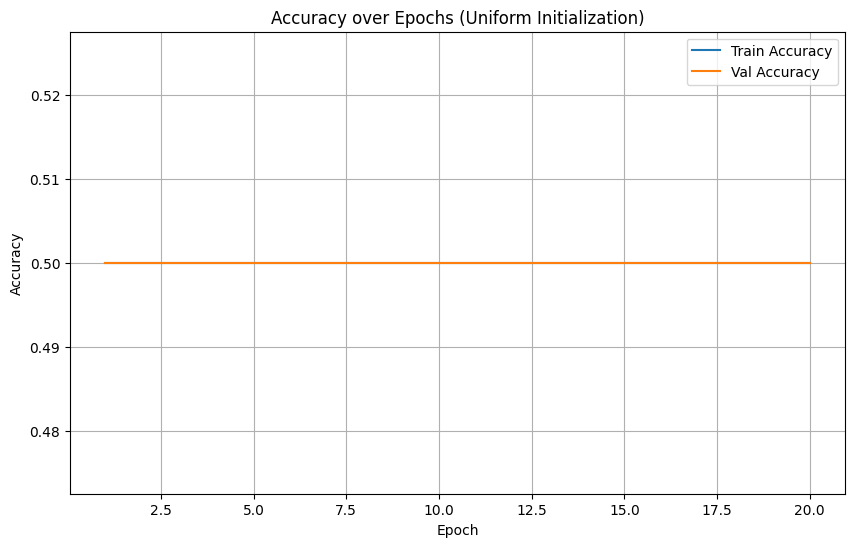

Testing initialization: gaussian


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 1/20 | Meta-loss: 0.8705 | Train Loss: 0.8705 | Val Loss: 0.8597 | Train Acc: 0.5000 | Val Acc: 0.5000
Epoch 2/20 | Meta-loss: 0.8513 | Train Loss: 0.8513 | Val Loss: 0.8451 | Train Acc: 0.5000 | Val Acc: 0.5000
Epoch 3/20 | Meta-loss: 0.8397 | Train Loss: 0.8397 | Val Loss: 0.8397 | Train Acc: 0.5000 | Val Acc: 0.5000
Epoch 4/20 | Meta-loss: 0.8333 | Train Loss: 0.8333 | Val Loss: 0.8287 | Train Acc: 0.5000 | Val Acc: 0.5000
Epoch 5/20 | Meta-loss: 0.8320 | Train Loss: 0.8320 | Val Loss: 0.8245 | Train Acc: 0.5000 | Val Acc: 0.5000
Epoch 6/20 | Meta-loss: 0.8153 | Train Loss: 0.8153 | Val Loss: 0.8168 | Train Acc: 0.5000 | Val Acc: 0.5000
Epoch 7/20 | Meta-loss: 0.8095 | Train Loss: 0.8095 | Val Loss: 0.8078 | Train Acc: 0.5000 | Val Acc: 0.5000
Epoch 8/20 | Meta-loss: 0.8057 | Train Loss: 0.8057 | Val Loss: 0.8019 | Train Acc: 0.5000 | Val Acc: 0.5000
Epoch 9/20 | Meta-loss: 0.8002 | Train Loss: 0.8002 | Val Loss: 0.7968 | Train Acc: 0.5000 | Val Acc: 0.5000
Epoch 10/20 | Meta-

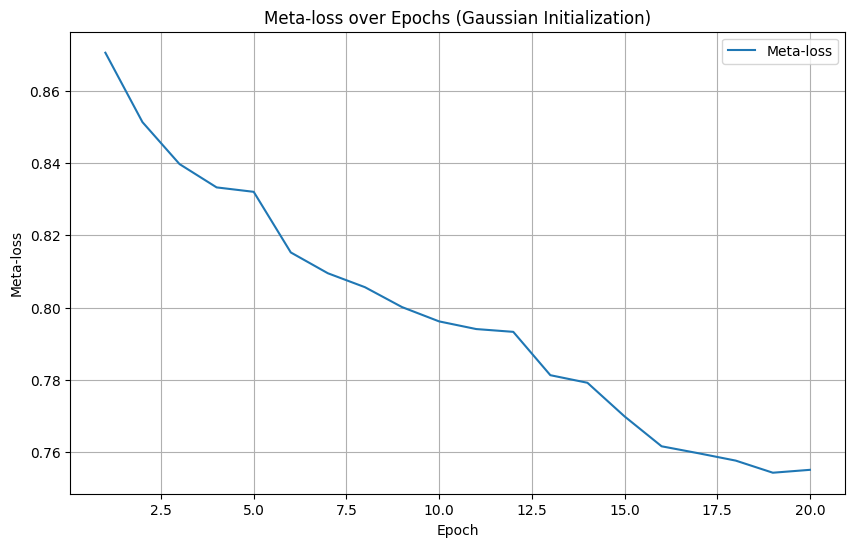

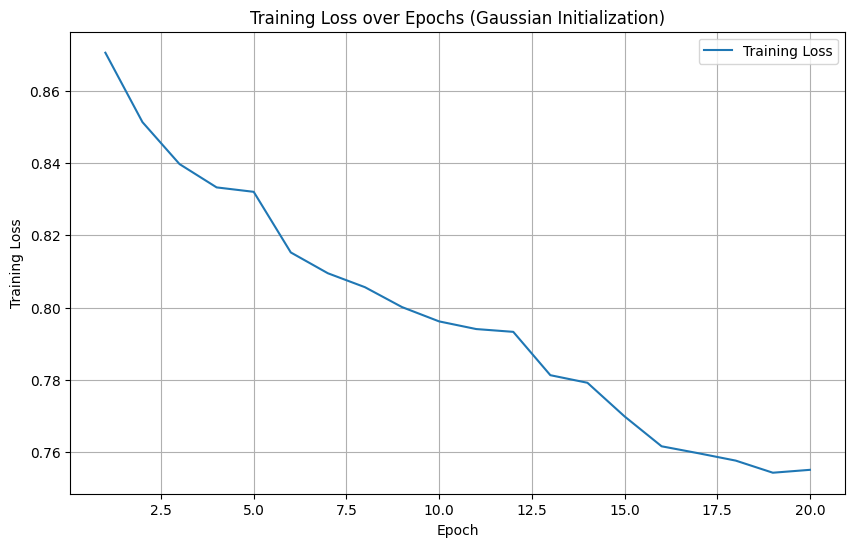

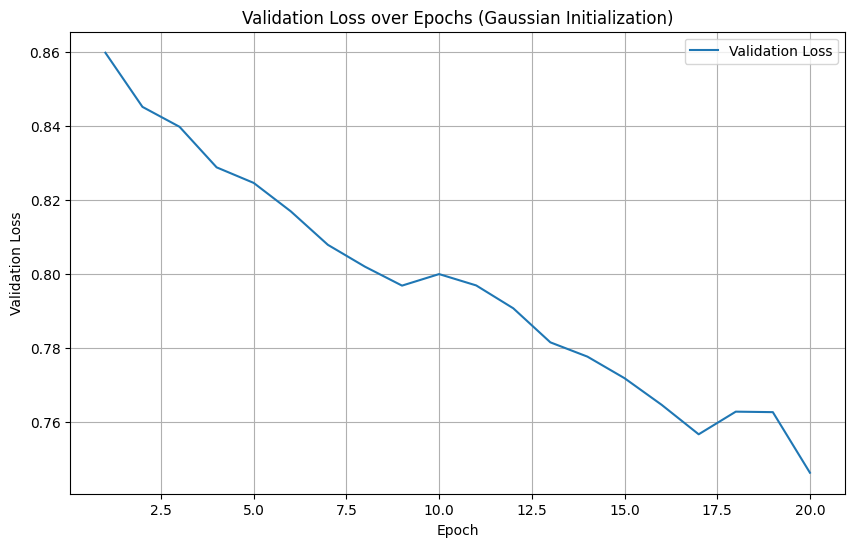

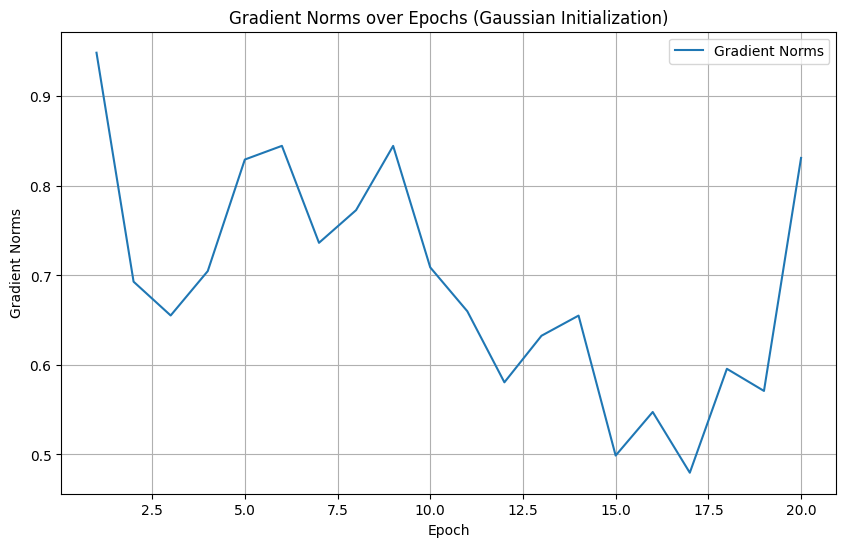

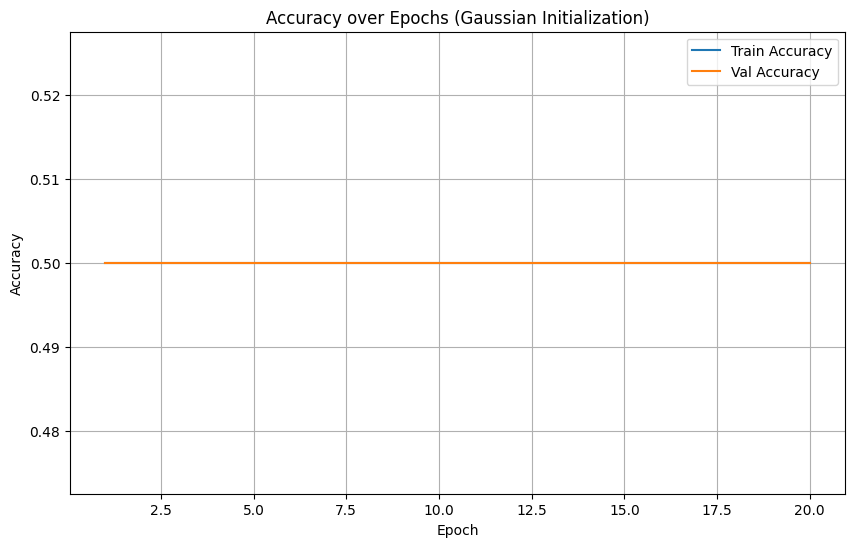

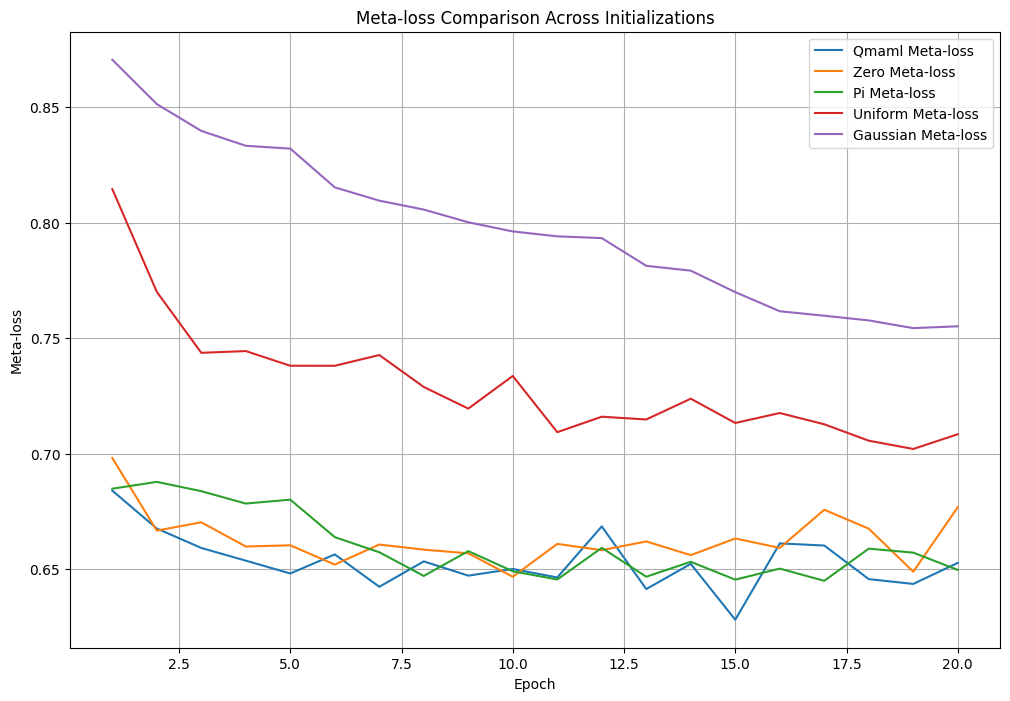

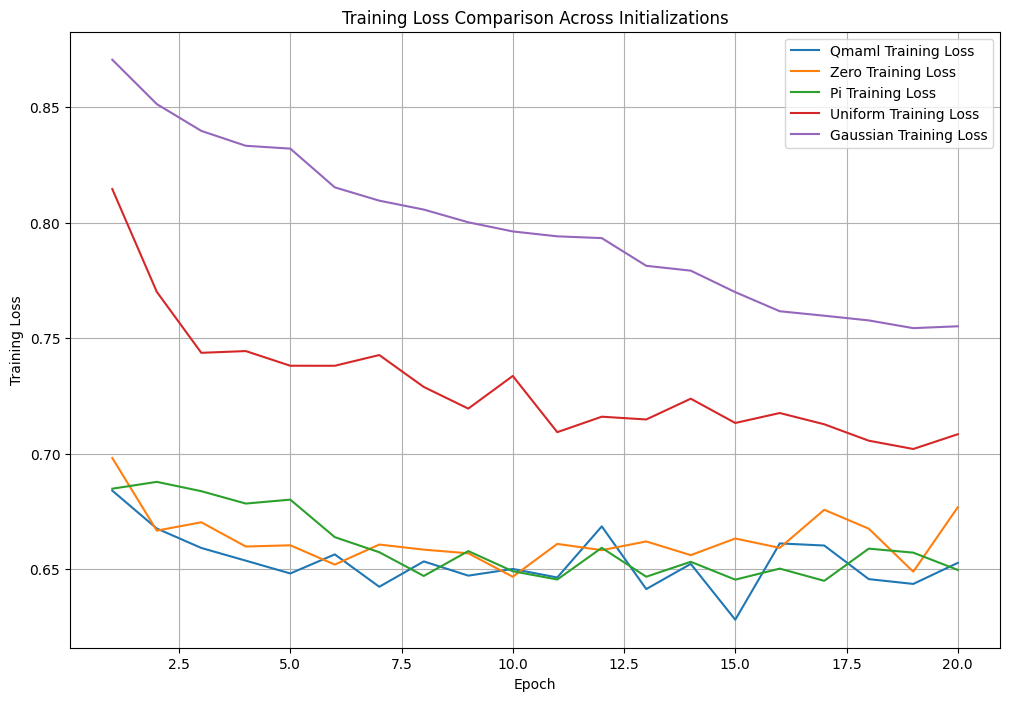

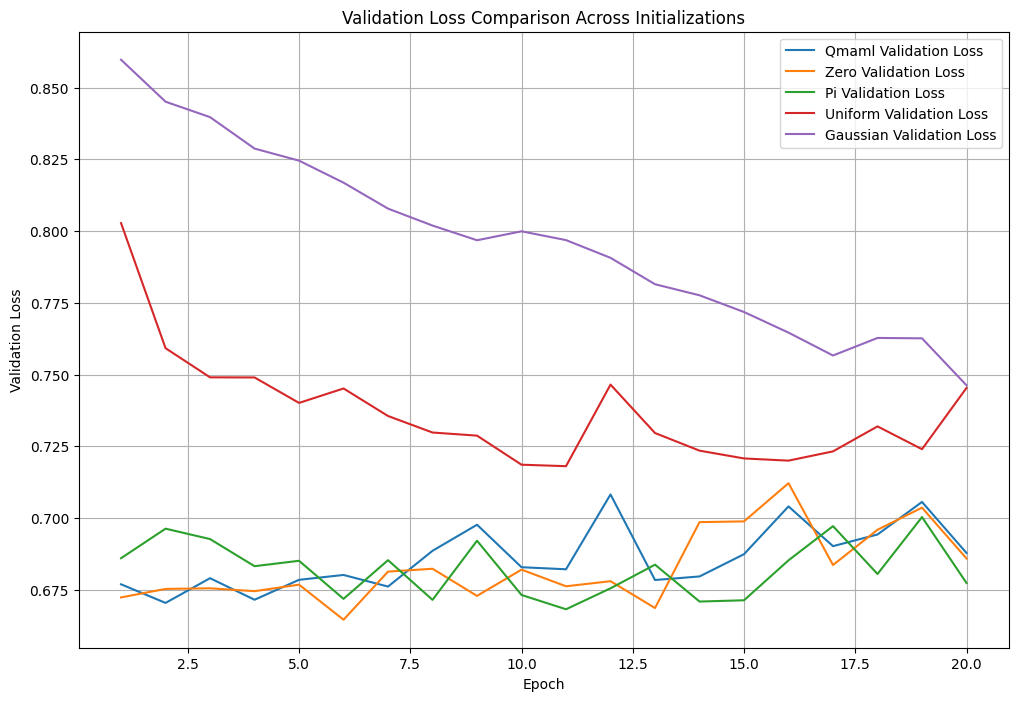

In [14]:
# --- Cell 11: Run Experiments (fresh CNN each time) ---
initialization_types = ["qmaml", "zero", "pi", "uniform", "gaussian"]
results = {}

test_meta_tasks = generate_meta_tasks(
    test_dataset,
    meta_task_types=config.META_TASK_TYPE,
    bin_count=config.META_BIN_COUNT,
    support_size=config.SUPPORT_SIZE,
    query_size=config.QUERY_SIZE,
)

for init_type in initialization_types:
    print(f"Testing initialization: {init_type}")
    # fresh CNN for each run
    cnn_extractor = CNNFeatureExtractor(config.CNN_OUTPUT_DIM, config.NUM_QUBITS)
    pqc_model = PQCModel(config.NUM_QUBITS, config.Q_DEPTH, init_type=init_type)
    hybrid_model = HybridModel(cnn_extractor, pqc_model)

    training_results = outer_loop_meta_update(
        hybrid_model,
        meta_tasks,
        test_meta_tasks,
        config.OUTER_LR,
        config.EVAL_METRICS,
    )
    results[init_type] = training_results
    plot_training_results(training_results, init_type)

plot_comparison(results)
